In [1]:
import datetime as dt
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
%matplotlib inline

#Size of matplotlib plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

## The next cell loads data from the John Hopkins github repository on the Corona virus: https://github.com/CSSEGISandData/COVID-19

If you want to run this code, make sure that the paths below are correctly pointing to a copy of the John Hopkins repository.

In [103]:
today = dt.date.today(); today

datetime.date(2020, 4, 20)

In [104]:
#Load data locally
data_confirmed = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
data_deaths = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
data_recovered = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#Load data from Internet
#data_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#data_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#data_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

data = [data_confirmed, data_deaths, data_recovered]

#mask = data_confirmed_orig.drop(["Lat","Long"], axis = 1).sum(numeric_only=True, axis=1)>100
for i in range(len(data)):
    #d.loc[d["Province/State"].notna(), "Country/Region"] += ' ' + d.loc[d["Province/State"].notna(), "Province/State"]
    try:
        data[i].drop(["Province/State", "Lat", "Long"] ,axis = 1, inplace=True)
        data[i]=data[i].groupby('Country/Region').sum()
    except KeyError:
        pass
    cols = data[i].columns
    new_cols = map(lambda x: dt.date(2020,*[int(x.split('/')[k]) for k in [0,1]]), cols)
    #d.drop([i for i in range(d.shape[0]) if mask[i]!=True], inplace=True) #Drops countries with less than 100 cases
    data[i].set_axis(list(new_cols), axis=1, inplace=True)
    data[i].reset_index(inplace=True)
    if i == 0:
        small_infection_number = [j for j in range(data[0].shape[0]) if data[0].iloc[j,-1]<200]
    data[i].drop(small_infection_number,inplace=True)
    data[i].reset_index(inplace=True)
    data[i].drop('index',axis=1,inplace=True)
    #d.set_axis(range(len(d.index)), axis=0, inplace=True)

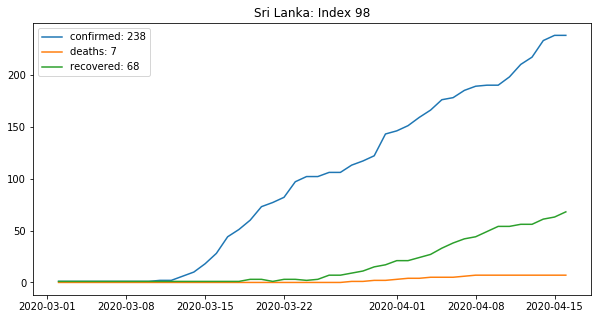

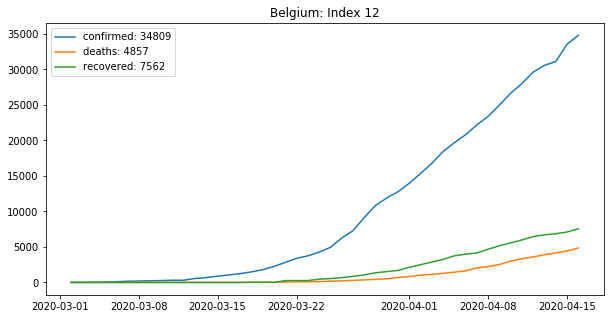

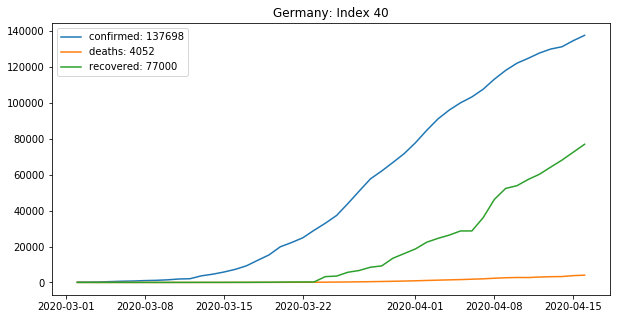

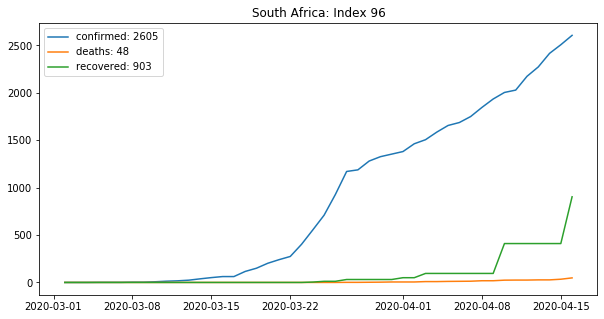

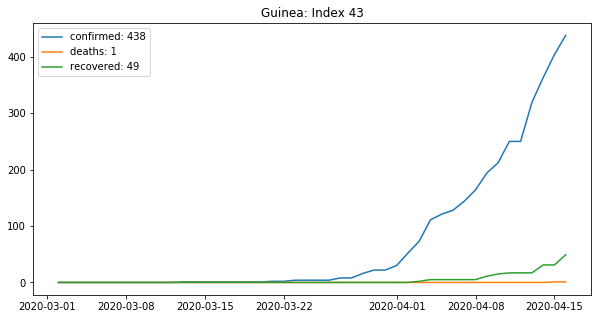

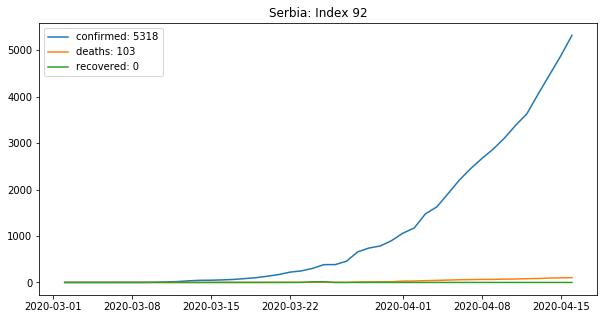

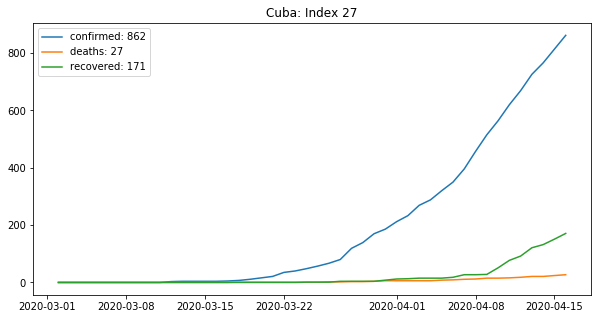

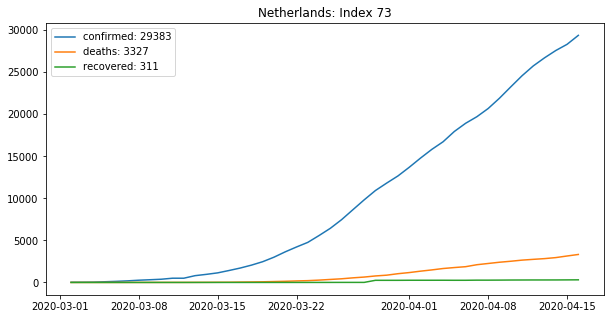

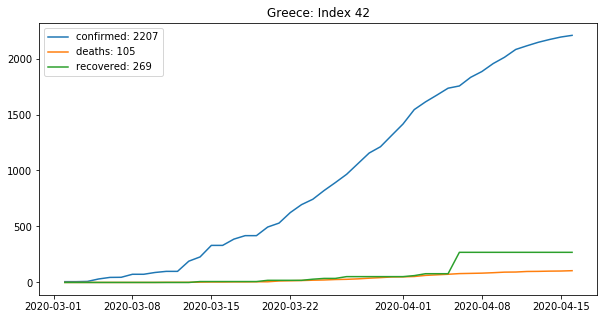

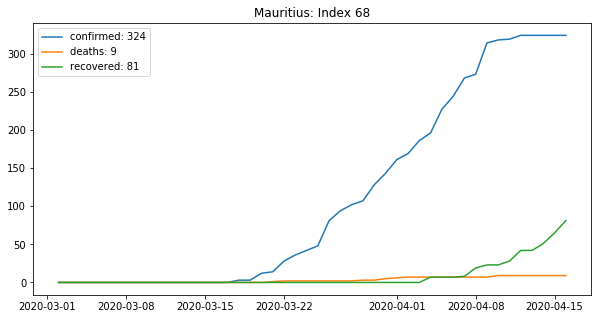

In [105]:
sample_size = 10
sample = random.sample(range(data[0].shape[0]),sample_size)
for index in sample:
    country = data[0].iloc[index][0]
    df = pd.DataFrame([d.iloc[index][1:] for d in data], index=[0,1,2]).fillna(0)
    total = df.iloc[:,-1]
    df.set_axis(["confirmed: {}".format(total.loc[0]),"deaths: {}".format(total[1]),"recovered: {}".format(total[2])], inplace=True, axis=0)
    df.T[40:].plot(title=country + ': Index {}'.format(index))


## Trying to interpolate the data with an exponential function shows that the growth of infections is subexponential

In [106]:
L = ["Austria", "Ireland", "Germany", "Italy", "US"]

Austria
Latest available data from date 2020-04-16: 14476
Reg score 0.8232896814866769
Reg coeff [[0.08065006]]
Intercept [7.53023491]
Prediction for 2020-04-16:  [[24613.17022156]]
Actual value:  7    14476.0
Name: 2020-04-16, dtype: float64
Prediction for 2020-04-17:  [[26680.46736286]]
Ireland
Latest available data from date 2020-04-16: 13271
Reg score 0.9353848650572735
Reg coeff [[0.12908924]]
Intercept [5.72626319]
Prediction for 2020-04-16:  [[19093.79611739]]
Actual value:  51    13271.0
Name: 2020-04-16, dtype: float64
Prediction for 2020-04-17:  [[21724.76182354]]
Germany
Latest available data from date 2020-04-16: 137698
Reg score 0.890878147806267
Reg coeff [[0.09127841]]
Intercept [9.40867396]
Prediction for 2020-04-16:  [[226292.37976985]]
Actual value:  40    137698.0
Name: 2020-04-16, dtype: float64
Prediction for 2020-04-17:  [[247920.04407065]]
Italy
Latest available data from date 2020-04-16: 168941
Reg score 0.9087835719852735
Reg coeff [[0.0555818]]
Intercept [10.5

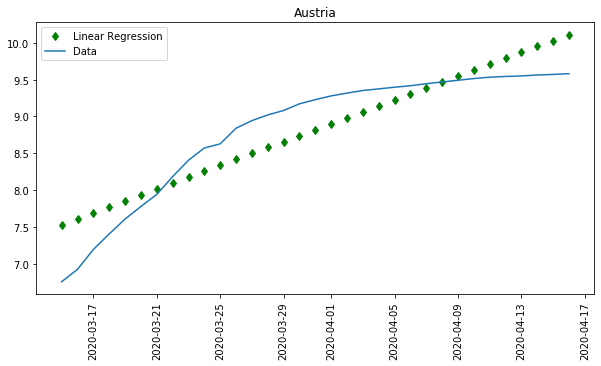

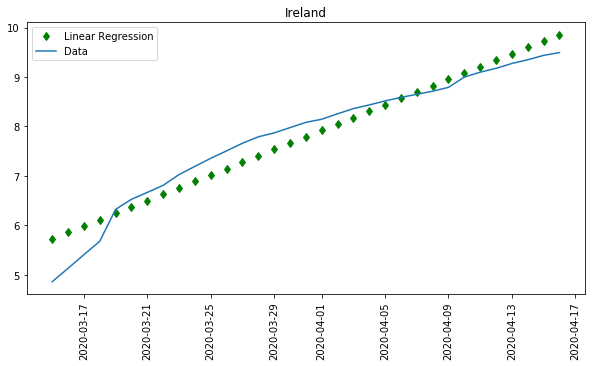

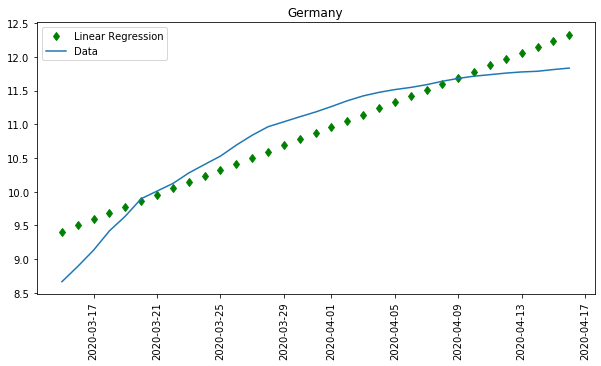

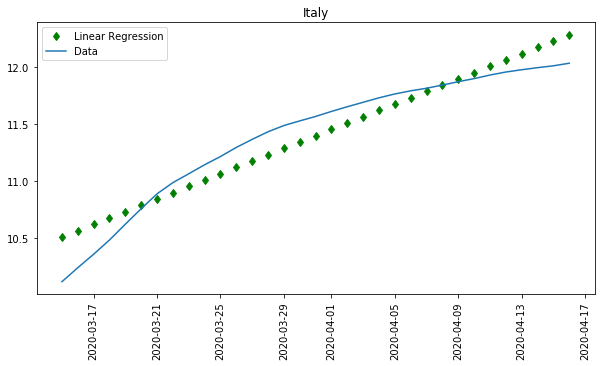

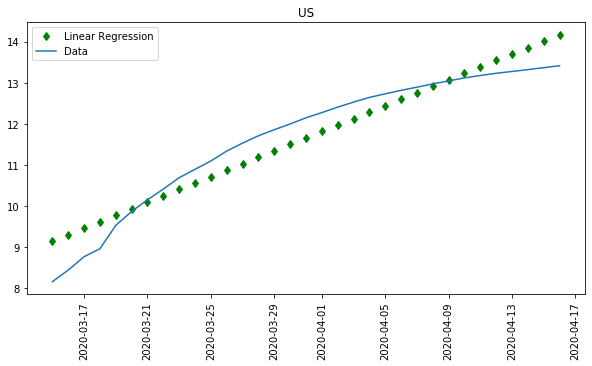

In [107]:
from sklearn.linear_model import LinearRegression
#import statsmodels.formula.api as sm
for country in L:
    y = data[0].loc[data[0]["Country/Region"]==country].iloc[:,1:].transpose()
    start_date = dt.date(2020,3,15)
    y = y.loc[start_date:today]
    y = y[y!=0].dropna().apply(np.log)
    #y = y.append(pd.Series({y.columns[0]:np.log(newest_data[country])}, name=pd.datetime(20,3,17)))
    X = np.array(range(y.shape[0])).reshape(-1,1)
    reg = LinearRegression()
    reg.fit(X,y)
    print(country)
    print('Latest available data from date {}: {}'.format(data[0].columns[-1], data[0].loc[data[0]["Country/Region"]==country].iloc[0,-1]))
    print('Reg score', reg.score(X, y))
    print('Reg coeff', reg.coef_)
    print('Intercept', reg.intercept_)
    plt.figure()
    plt.plot(y.index,(reg.predict(X)), 'gd', label='Linear Regression')
    plt.plot(y.index, (np.array(y)), label='Data')
    plt.title(country)
    plt.legend(loc="best")
    plt.xticks(rotation='vertical')
    print('Prediction for {}: '.format(data[0].columns[-1]), np.exp(reg.predict((X[-1]).reshape(-1,1))))
    print('Actual value: ', np.exp(y.iloc[-1]))
    print('Prediction for {}: '.format(data[0].columns[-1]+dt.timedelta(1)), np.exp(reg.predict((X[-1]+1).reshape(-1,1))))
    
    #reg.predict(np.array([[3, 5]]))

## Let's divide the data by population size. 
We can either add the population value (from the year 2016) to the data, as is demonstrated below or just find the population_data when we need it.

One can also try to merge with the following command:
pd.merge(data[0], population_data,  how='inner', left_on='Country/Region', right_on='Country Name',
         sort=True, suffixes=('_x', '_y'), copy=True)

In [ ]:
countries = data[0]['Country/Region']

In [126]:
#We don't need to update population data that often, so by default we just load it from a local csv. This cell gets the data and cleans it.

population_data = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
population_data = population_data.drop([i for i in range(population_data.shape[0]) if population_data.iloc[i]['Year']<2018])
population_data = population_data.set_index('Country Name').drop(['Year','Country Code'],axis=1)
#Some Countries in population_data have other names. Check which
for i,c in countries.iteritems():
    if c not in population_data.index.values: print(c)
#Check how they are called in population data, e.g., for Venezuela:
print(population_data.loc[population_data.index.str.contains('Ven')])
#The following countries names need to be replaced
population_data = population_data.rename(index={'Venezuela, RB':'Venezuela','Congo, Rep.':'Congo (Kinshasa)','Kyrgyz Republic': 'Kyrgyzstan', 'Macedonia, FYR':'North Macedonia','Iran, Islamic Rep.':'Iran','Egypt, Arab Rep.':'Egypt','Czech Republic':'Czechia','United States':'US', 'Russian Federation':'Russia', 'Korea, Rep.' : 'Korea, South', 'Slovak Republic':'Slovakia'})
population_data = population_data.drop([population_data.index[i] for i in range(population_data.shape[0]) if population_data.index[i] not in countries.values])
taiwan_population = 23574274; diamond_princess_population = 3600
population_data.loc['Taiwan*'] = taiwan_population
population_data.loc['Diamond Princess'] = diamond_princess_population
population_data.to_csv(r'population_data.csv', index = True)

Congo (Kinshasa)
Czechia
Diamond Princess
Egypt
Iran
Korea, South
Kyrgyzstan
Russia
Slovakia
Taiwan*
US
Venezuela
                  Value
Country Name           
Venezuela, RB  28870195


In [122]:
population_data = pd.read_csv('population_data.csv')

In [123]:
data[0] = data[0].set_index('Country/Region')

In [124]:
def divide_by_population(x):
    country = x.name

    population = population_data.loc[country].values

    return x/population*100000

infections_relative = data[0].apply(divide_by_population,axis=1)

KeyError: 'Afghanistan'

In [125]:
population_data

,Value
0,37172386
1,2866376
2,42228429
3,77006
4,44494502
...,...
109,28870195
110,95540395
111,4569087
112,23574274


## Let's look at the 15 most infected countries (relatively and according to reported numbers...). 
We exclude the first four because they are small: Diamond Princess, San Marino, Andorra, Luxembourg

In [82]:
most_infected = infections_relative.sort_values(axis=0, by=infections_relative.columns[-1], ascending=False)[4:16]

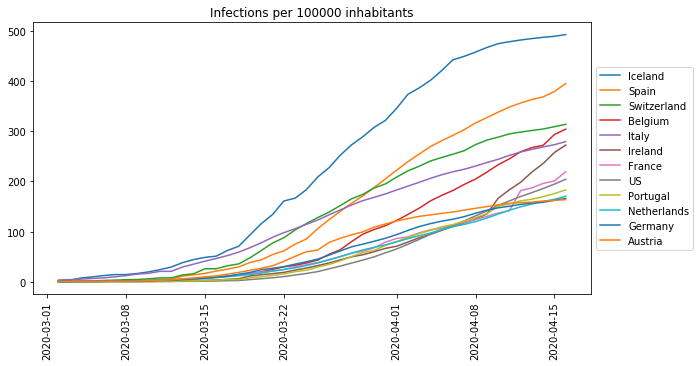

In [83]:
f = plt.figure()
plt.title('Infections per 100000 inhabitants')
most_infected.T[40:].plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.xticks(rotation='vertical')
plt.show()

## Let's look at a new graph: The start date for every country is set to the first date it reaches infection_threshhold infected per 100000 inhabitants

In [84]:
infection_threshhold = 20

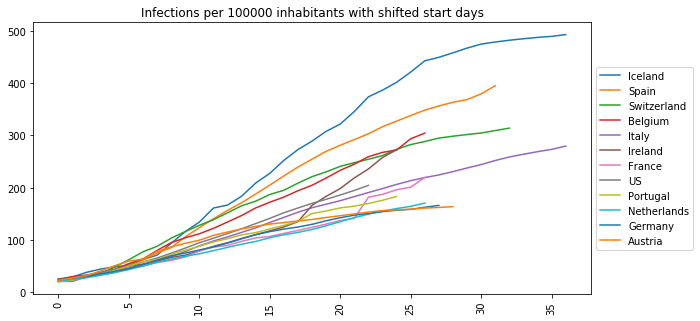

In [89]:
f = plt.figure()
plt.title('Infections per 100000 inhabitants with shifted start days')
for i in most_infected.index:
    start = most_infected.loc[i].ge(infection_threshhold).idxmax()
    tmp = most_infected.loc[i][start:].reset_index(drop=True)
    #print(tmp)
    #break
    tmp.plot()
    
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.xticks(rotation='vertical')
plt.show()